# Fire Avoidance: Within-Subject 
# n=30


In [ ]:
#!/usr/bin/env python3
import seaborn as sns
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import json
import ast
from collections import Counter

sns.set_theme(style="white",font_scale=2.1)

# Config.
CSV_PATH      = "game_trials_export.csv"
SUBJECT_COL   = "prolificId"
PHASE_COL     = "phase"
VEHICLE_COL   = "vehicleType"
PLAN_COL      = "plan_seq"
DANGEROUS_COL = "dangerous_vehicle"
WORRY_COL     = "worry"
SOMA_COL      = "somatic_anxiety"
HITS_COL      = "hits"

# valid keys.
VALID_KEYS = {
    "small_car"   : ["a","d","w","x"],
    "big_car"     : ["s","f","e","c"],
    "medium_car"  : ["a","s","d","f","w","e","x","c"],
    "small_sedan" : ["g","j","y","n"],
    "big_sedan"   : ["h","k","u","m"],
    "medium_sedan": ["g","h","j","k","y","u","n","m"],
}

# Map from direction to index
DIRECTION_TO_INDEX = {
    "left": 0,
    "right": 1,
    "up": 2,
    "down": 3
}

BIG_SMALL_SET = {"small_car","big_car","small_sedan","big_sedan"}

In [ ]:
def parse_plan(seq):
    """Return list of lowercase letters f1om plan_seq (ignore non-letters)."""
    if not isinstance(seq, str):
        return []
    return [ch.lower() for ch in seq if ch.isalpha()]

def parse_json_list(cell):
    if pd.isna(cell):
        return []
    s = str(cell).strip()
    try:
        return json.loads(s)
    except Exception:
        return [p.strip().lower() for p in re.split(r"[,\s]+", s) if p.strip()]
    
def contains_obstacle(x):
    return any(str(v).lower().strip() == "obstacle" for v in parse_json_list(x))

def get_obstacle_moves(row):
    return [move for hit, move in zip(row['hits'], row['routeTaken']) if hit == 'obstacle']


# Function to map obstacleMoves to keys based on vehicleType
def map_moves_to_keys(row):
    vehicle = row["vehicleType"]
    directions = row["obstacleMoves"]
    keyset = VALID_KEYS.get(vehicle, [])
    keys = []
    for direction in directions:
        idx = DIRECTION_TO_INDEX.get(direction)
        if idx is not None and idx < len(keyset):
            keys.append(keyset[idx])
        else:
            keys.append(None) 
    return keys



def parse_and_clean(seq):
    """Parse string to list, then keep only alphabetic lowercase keys."""
    if isinstance(seq, str):
        try:
            parsed = ast.literal_eval(seq)
        except:
            return []
    elif isinstance(seq, list):
        parsed = seq
    else:
        return []

    return parse_plan(parsed) 


In [ ]:

df = pd.read_csv(CSV_PATH)
df1 = df[df[PHASE_COL]==1].copy()
df2 = df[df[PHASE_COL]==2].copy()

df1_with_obstacle = df1[df1["hits"].apply(contains_obstacle)].copy()

# Converting to lists
df1_with_obstacle['hits'] = df1_with_obstacle['hits'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
df1_with_obstacle['routeTaken'] = df1_with_obstacle['routeTaken'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)

# Aligning obstacle with move
df1_with_obstacle['obstacleMoves'] = df1_with_obstacle.apply(get_obstacle_moves, axis=1)
df1_with_obstacle["obstacleKeys"] = df1_with_obstacle.apply(map_moves_to_keys, axis=1)
print(df1_with_obstacle[['hits', 'routeTaken', 'obstacleMoves', 'obstacleKeys', VEHICLE_COL]])



                                                   hits  \
815          [obstacle, reward, reward, reward, reward]   
1051  [reward, obstacle, obstacle, reward, reward, r...   
1201         [reward, obstacle, reward, reward, reward]   
1837         [obstacle, reward, reward, reward, reward]   
2139         [reward, reward, obstacle, reward, reward]   

                                         routeTaken obstacleMoves  \
815                   [left, down, down, right, up]        [left]   
1051  [down, down, left, left, up, up, right, down]  [down, left]   
1201         [down, left, left, down, right, right]        [left]   
1837                  [right, down, down, left, up]       [right]   
2139            [left, down, right, left, left, up]       [right]   

     obstacleKeys  vehicleType  
815           [a]    small_car  
1051       [x, a]    small_car  
1201          [a]    small_car  
1837          [j]  small_sedan  
2139          [d]    small_car  


In [92]:
subjects_with_obstacle_keys_phase1={d['prolificId']: d['obstacleKeys'] for d in df1_with_obstacle[[SUBJECT_COL,'obstacleKeys']].to_dict("records")}

In [ ]:
# The trial where an obstacle was hit in phase 1
print(df1_with_obstacle.shape)
df1_with_obstacle.head()


(5, 36)


,phase,vehicle,startTime,moves,rewardsCollected,obstaclesHit,routeTaken,actions,lastValidKeyTime,hits,...,correctLL,generalized_correctness_topdown,generalized_correctness_leftright,bias_second_order_valid,bias_second_order_correct,type_generalization,optimalRoute,dangerous_vehicle,worry,somatic_anxiety
815,1,NaN,NaN,NaN,4,1,"[""left"",""down"",""down"",""right"",""up""]",NaN,NaN,"[""obstacle"",""reward"",""reward"",""reward"",""reward""]",...,NaN,NaN,NaN,NaN,NaN,NaN,"[""down"",""down"",""left"",""up""]",small_car,31,29
1051,1,NaN,NaN,NaN,4,2,"[""down"",""down"",""left"",""left"",""up"",""up"",""right""...",NaN,NaN,"[""reward"",""obstacle"",""obstacle"",""reward"",""rewa...",...,NaN,NaN,NaN,NaN,NaN,NaN,"[""down"",""left"",""up"",""left""]",small_car,29,34
1201,1,NaN,NaN,NaN,4,1,"[""down"",""left"",""left"",""down"",""right"",""right""]",NaN,NaN,"[""reward"",""obstacle"",""reward"",""reward"",""reward""]",...,NaN,NaN,NaN,NaN,NaN,NaN,"[""down"",""down"",""left"",""left""]",big_car,16,11
1837,1,NaN,NaN,NaN,4,1,"[""right"",""down"",""down"",""left"",""up""]",NaN,NaN,"[""obstacle"",""reward"",""reward"",""reward"",""reward""]",...,NaN,NaN,NaN,NaN,NaN,NaN,"[""down"",""down"",""right"",""up""]",big_car,40,26
2139,1,NaN,NaN,NaN,4,1,"[""left"",""down"",""right"",""left"",""left"",""up""]",NaN,NaN,"[""reward"",""reward"",""obstacle"",""reward"",""reward""]",...,NaN,NaN,NaN,NaN,NaN,NaN,"[""left"",""left"",""down"",""right""]",small_car,19,13


                                                   hits dangerous_vehicle  \
815          [obstacle, reward, reward, reward, reward]         small_car   
1051  [reward, obstacle, obstacle, reward, reward, r...         small_car   
1201         [reward, obstacle, reward, reward, reward]           big_car   
1837         [obstacle, reward, reward, reward, reward]           big_car   
2139         [reward, reward, obstacle, reward, reward]         small_car   

      vehicleType  
815     small_car  
1051    small_car  
1201    small_car  
1837  small_sedan  
2139    small_car  
Matches: 3/5 (60.0%)


C:\Users\hadas\AppData\Local\Temp\ipykernel_60196\157162358.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="match", data=df1_with_obstacle, palette=["#dd8452", "#4c72b0"])


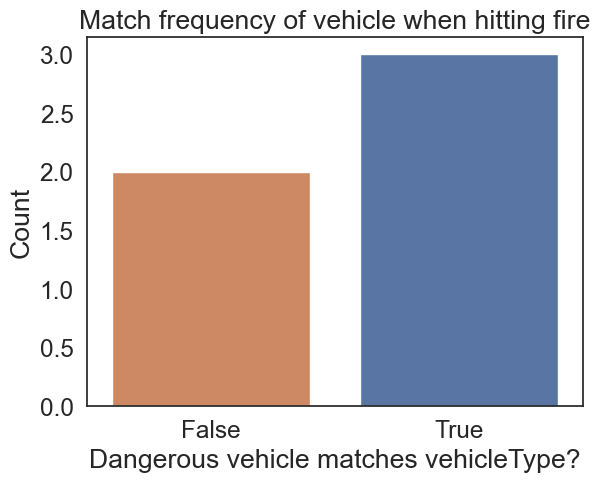

In [142]:
print(df1_with_obstacle[['hits', 'dangerous_vehicle', VEHICLE_COL]])

matches = df1_with_obstacle["dangerous_vehicle"] == df1_with_obstacle[VEHICLE_COL]
match_count = matches.sum()
total_count = len(matches)

print(f"Matches: {match_count}/{total_count} ({match_count/total_count:.1%})")

sns.set_theme(style="white", font_scale=1.6)

df1_with_obstacle["match"] = matches
sns.countplot(x="match", data=df1_with_obstacle, palette=["#dd8452", "#4c72b0"])
plt.xlabel("Dangerous vehicle matches vehicleType?")
plt.ylabel("Count")
plt.title("Match frequency of vehicle when hitting fire")
plt.show()



In [ ]:
df2.groupby([SUBJECT_COL])[PLAN_COL].apply()

In [ ]:
# Parsing the plan sequence
df2[PLAN_COL] = df2[PLAN_COL].apply(parse_plan)
print(df2[['phase', PLAN_COL, VEHICLE_COL, SUBJECT_COL]])


      phase      plan_seq   vehicleType                prolificId
61        2  [w, a, a, x]     small_car  5b90635a877eab0001d7ba9e
62        2  [w, w, a, x]  medium_sedan  5b90635a877eab0001d7ba9e
63        2  [w, a, x, x]  medium_sedan  5b90635a877eab0001d7ba9e
64        2  [d, w, w, a]    medium_car  5b90635a877eab0001d7ba9e
65        2  [x, a, a, w]  medium_sedan  5b90635a877eab0001d7ba9e
...     ...           ...           ...                       ...
2545      2  [w, d, x, x]     big_sedan  66f83b5d25dbe66347fbfb7b
2546      2  [w, a, x, d]    medium_car  66f83b5d25dbe66347fbfb7b
2547      2  [d, d, w, a]  medium_sedan  66f83b5d25dbe66347fbfb7b
2548      2  [d, x, x, a]       big_car  66f83b5d25dbe66347fbfb7b
2549      2  [x, x, a, a]     big_sedan  66f83b5d25dbe66347fbfb7b

[720 rows x 4 columns]


In [ ]:
# The subject id of users who hit an obstacle in phase 1 - and the keys that caused it
subjects_with_obstacle_keys_phase1

{'6691a5c500af8a7d634133f7': ['a'],
 '5e909d6c5321c13abee11725': ['x', 'a'],
 '57a1e03b8eccbc0001f39c13': ['a'],
 '6146548679f86b7cb069e7f7': ['j'],
 '676a572fbab37b8829bf8ebc': ['d']}

In [ ]:
# Keeping only whats not null
df2 = df2[df2[PLAN_COL].apply(lambda l: len(l)>0)]

subject_keys_phase2 = df2.explode([PLAN_COL]).groupby([SUBJECT_COL]).agg({PLAN_COL: list}).to_dict()
subject_keys_phase2 = subject_keys_phase2['plan_seq']
# the frequency of each key pressed by users in phase 2 
subject_key_freq_phase2 = {subject: dict(Counter(k)) for subject, k in subject_keys_phase2.items()}
subject_key_freq_phase2

{'57a1e03b8eccbc0001f39c13': {'d': 20, 'w': 28, 'a': 22, 'x': 26},
 '59a9c0291b7a550001d6392e': {'a': 20,
  'u': 2,
  'w': 25,
  'j': 16,
  'x': 26,
  'k': 3},
 '5b90635a877eab0001d7ba9e': {'w': 28, 'a': 21, 'x': 27, 'd': 20},
 '5bd2034025db7b000178ad8a': {'x': 22,
  'd': 19,
  'e': 3,
  'f': 1,
  'c': 1,
  'w': 23,
  'a': 27},
 '5c4782d9cae0ab000188d2b4': {'w': 9,
  'a': 5,
  'x': 8,
  'e': 8,
  's': 11,
  'c': 10,
  'd': 10,
  'f': 3,
  'k': 8,
  'u': 11,
  'h': 5,
  'm': 8},
 '5d68c8aa40524c00189e8ac2': {'x': 27, 'd': 20, 'w': 28, 'a': 21},
 '5e909d6c5321c13abee11725': {'k': 3,
  'u': 6,
  'h': 10,
  'd': 3,
  'w': 4,
  'a': 1,
  'j': 20,
  'y': 15,
  'g': 25,
  't': 1},
 '5f1dfd940aeb060d8eb3cf55': {'a': 23,
  'd': 24,
  's': 22,
  'x': 2,
  'r': 1,
  'w': 23,
  'h': 1},
 '5f5452df72345118f58d187b': {'w': 28, 'a': 22, 'x': 26, 'd': 20},
 '5f71935e1b5cc67c14c657b1': {'w': 19,
  'd': 12,
  'x': 19,
  'u': 10,
  'k': 7,
  'n': 6,
  'a': 17,
  'h': 4,
  'm': 1,
  's': 1},
 '6146548679f

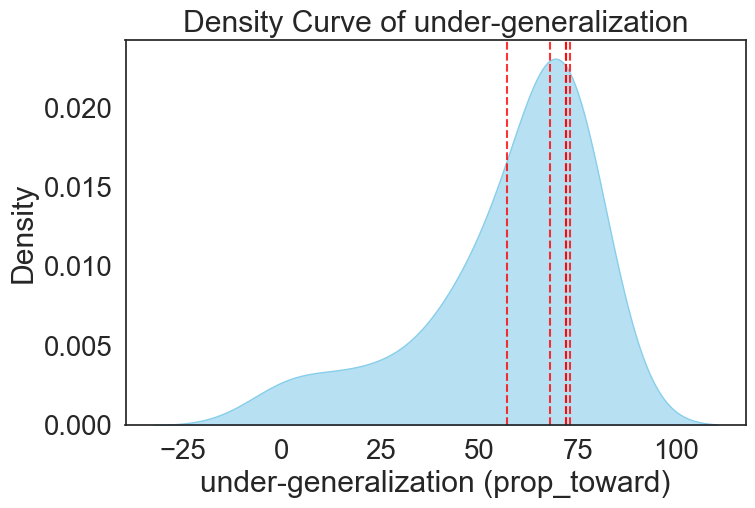

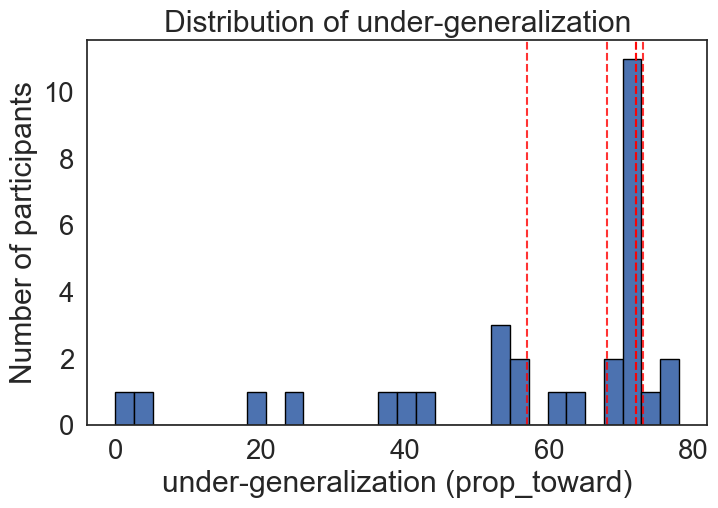

In [126]:
df_summ = pd.read_csv('./participant-summary.csv')
highlight_ids = list(subjects_with_obstacle_keys_phase1.keys())
highlight_vals = df_summ.loc[df_summ["participant"].isin(highlight_ids), "prop_toward"]

sns.set_theme(style="white", font_scale=1.8)

# KDE with vertical lines
plt.figure(figsize=(8,5))
sns.kdeplot(df_summ["prop_toward"].dropna(), fill=True, color="skyblue", alpha=0.6)
for val in highlight_vals:
    plt.axvline(val, color='red', linestyle='--', alpha=0.8)
plt.xlabel("under-generalization (prop_toward)")
plt.ylabel("Density")
plt.title("Density Curve of under-generalization")
plt.show()

# Histogram with vertical lines
plt.figure(figsize=(8,5))
plt.hist(df_summ["prop_toward"].dropna(), bins=30, edgecolor='black')
for val in highlight_vals:
    plt.axvline(val, color='red', linestyle='--', alpha=0.8)
plt.xlabel("under-generalization (prop_toward)")
plt.ylabel("Number of participants")
plt.title("Distribution of under-generalization")
plt.show()

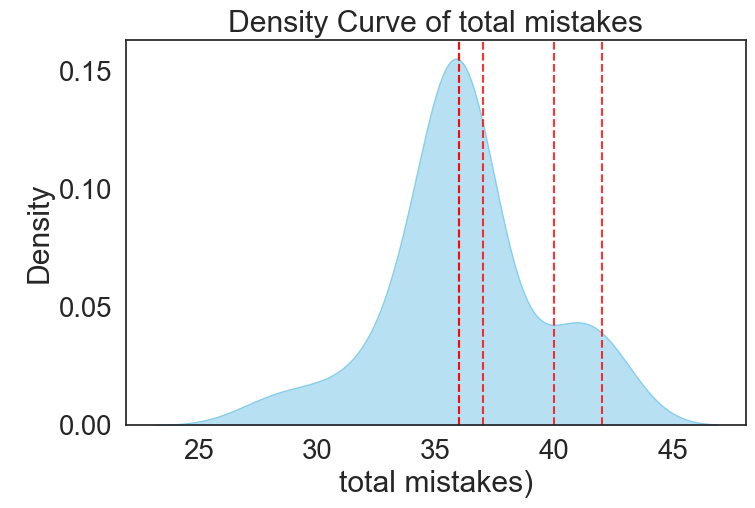

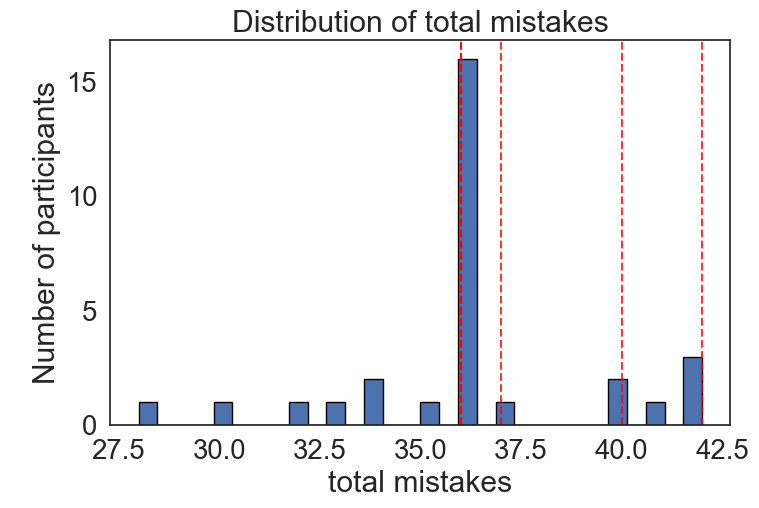

In [127]:
df_summ = pd.read_csv('./participant-summary.csv')
highlight_ids = list(subjects_with_obstacle_keys_phase1.keys())
highlight_vals = df_summ.loc[df_summ["participant"].isin(highlight_ids), "total_mistakes"]

sns.set_theme(style="white", font_scale=1.8)

# KDE with vertical lines
plt.figure(figsize=(8,5))
sns.kdeplot(df_summ["total_mistakes"].dropna(), fill=True, color="skyblue", alpha=0.6)
for val in highlight_vals:
    plt.axvline(val, color='red', linestyle='--', alpha=0.8)
plt.xlabel("total mistakes)")
plt.ylabel("Density")
plt.title("Density Curve of total mistakes")
plt.show()

# Histogram with vertical lines
plt.figure(figsize=(8,5))
plt.hist(df_summ["total_mistakes"].dropna(), bins=30, edgecolor='black')
for val in highlight_vals:
    plt.axvline(val, color='red', linestyle='--', alpha=0.8)
plt.xlabel("total mistakes")
plt.ylabel("Number of participants")
plt.title("Distribution of total mistakes")
plt.show()

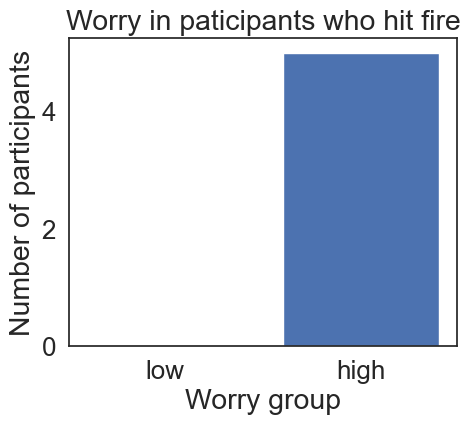

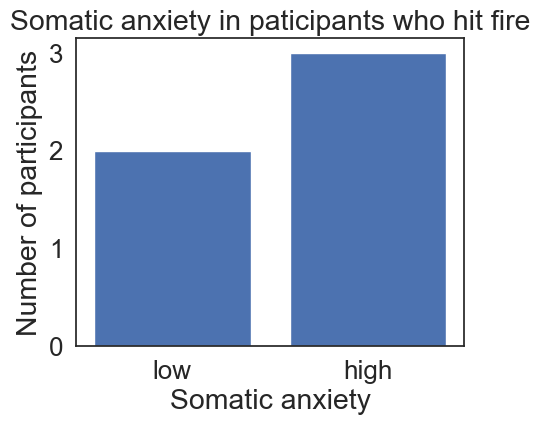

In [134]:
# Filter to just the highlight participants - the ones that hit fire in phase 1
highlight_df = df_summ[df_summ["participant"].isin(highlight_ids)]

worry_counts   = highlight_df["worry_grouped"].value_counts().reindex(["low","high"], fill_value=0)
somatic_counts = highlight_df["somatic_anxiety_grouped"].value_counts().reindex(["low","high"], fill_value=0)


sns.set_theme(style="white", font_scale=1.7)

# worry bar
plt.figure(figsize=(5,4))
plt.bar(worry_counts.index, worry_counts.values)
plt.xlabel("Worry group")
plt.ylabel("Number of participants")
plt.title("Worry in paticipants who hit fire")
plt.show()

# somatic anxiety bar
plt.figure(figsize=(5,4))
plt.bar(somatic_counts.index, somatic_counts.values)
plt.xlabel("Somatic anxiety")
plt.ylabel("Number of participants")
plt.title("Somatic anxiety in paticipants who hit fire")
plt.show()
